# 3D Dataset #

In [1]:
"""
PyTorch Giff Dataset Class for loading gifs using Pytorch DataLoader.
This Dataset resizes all frames to a specific size.

Facundo Calcagno
"""
from __future__ import print_function, division
import cv2
import os
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image,ImageFile,ImageFilter , ImageOps, ImageDraw
import imageio
import pandas as pd
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import glob
import time
from tqdm import tqdm,tqdm_notebook
from sklearn.metrics import recall_score
from skimage import transform
import random
import pickle
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss, Recall, Precision

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")


# Hierarchy #
We are going to work with different hierarchies to detect objects
1st hierarchy : Living or Not Living

In [3]:

def load_obj(name ):
    with open('../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
hier=pd.DataFrame(load_obj("hierarchy"),columns=("living","parent","child"))
classes_transf=load_obj("dictionary_classes")
hierclasses1=hier['living'].unique()
hierclasses2=hier['parent'].unique()
hierclasses3=hier['child'].unique()
transfpos=2
ImageFile.LOAD_TRUNCATED_IMAGES = True

#transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataset Class #

In [4]:
class plancton3DDataset(data.Dataset):
    """Dataset Class for loading Gif into a 3D Tensor"""
    def __init__(self,gifList,rootDir, channels,  timeDepth, xSize, ySize, 
                 startFrame,endFrame,numFilters,filters,keys,classes_transf,transfpos,transform=None):
        """
        Args:
        clipsList (string): Path to the clipsList file with labels.
        rootDir (string): Directory with all the 3D Images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        channels: Number of channels of frames
        timeDepth: Number of frames to be loaded in a sample to construct the 3D Matrix
        xSize, ySize: Dimensions of the frames
        startFrame,endFrame: first and last frame from the original gif
        filters: numbers of filters that you would input
        classes_trans: Transformation from folder name to class name
        transfpos: hierarchy to apply as output (0 is 'living' and 'not living')
        transform: transformation to apply to the frames
        """
        self.gifList = gifList
        self.rootDir = rootDir
        self.channels = channels
        self.timeDepth = timeDepth
        self.xSize = xSize
        self.ySize = ySize
        #self.mean = mean
        self.transform = transform
        self.startFrame=startFrame
        self.endFrame=endFrame
        self.numFilters=numFilters
        self.keys=keys
        #self.keys= pd.read_csv("../plancton_species.csv",delimiter=";",header=0,names =("0"))
        self.classes =[d for d in self.keys]
        self.classes.sort()
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.filters=filters
        self.classes_transf=classes_transf
        self.transfpos=transfpos

    def __len__(self):
        return len(self.gifList)
    
    def crop6(self,im):
        number_of_cols=3
        W=im.width
        H=im.height
        w=(W-16)/3
        h=(H-24)/2
        images=[]
        w1=0
        w2=w
        for i in range(number_of_cols):
            im1=im.crop((w1, 0, w2, h))
            images.append(im1)
            im1=im.crop((w1, h+8, w2, 2*h+8))
            images.append(im1)
            w1=w2+8
            w2=w2+w+8
        return images
    
    def readGif(self, gifFile):
        # Open the gif file, crop it and return the frames in a tensor
        image_gif=Image.open(gifFile, mode='r')
        width, height = image_gif.size
        w=(width-16)/3
        h=(height-24)/2
        #frames = torch.FloatTensor(self.numFilters,self.timeDepth,  
        #                            self.xSize, self.ySize)
        
        frames=np.zeros((self.numFilters,self.timeDepth,int(h), int(w)))
        nframes = 0
        nframesin=0

        while image_gif:
            if self.startFrame<=nframes<=self.endFrame:
                six_images=self.crop6(image_gif)
                for ifilter in range(self.numFilters):
                    realfilter=self.filters[ifilter]
                    if self.channels == 3: pil_image = six_images[realfilter].convert("RGB")
                    if self.channels == 1: pil_image = six_images[realfilter].convert("L") 
                    frame = np.asarray(pil_image).astype(np.float32)   
                    frames[ifilter,nframes, :, :] = frame
                nframesin+=1
            nframes += 1
            try:
                image_gif.seek( nframes )
            except EOFError:
                break;
            
        image_gif.close()
        return frames
    

    def __getitem__(self, idx):
        file,folder,typeplan=self.gifList.iloc[idx]
        typeplan=self.classes_transf[folder][self.transfpos]
        gifFile= os.path.join(self.rootDir, os.path.join(folder,file))
        clip = self.readGif(gifFile)
        if self.transform:
            clip = self.transform(clip)
        return clip,self.class_to_idx[typeplan]

## Transformation ##

In [5]:
## Transormations ##
   
class Rescale(object):
    """Rescale the 3 3D images in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size of widht ad height (Lenght stays the same) 
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image=sample
    
        c,f,h, w = image.shape
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        
        new_h, new_w = int(new_h), int(new_w)
        #Generate a resize
        frames=np.zeros((c,f,new_h, new_w))
        for c_i in range(c):
            for f_i in range(f):
                new_image=transform.resize(image[c_i,f_i,:,:],(new_h, new_w))
                frames [c_i,f_i,:,:]=new_image
        
        return frames

class RandomCrop(object):
    """Crop randomly the 3D image in a sample, using the same crop for all filters and frames
    
    Args:
        output_size (tuple or int): Desired output size of each frame of each filter. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image= sample
        
        c,f,h, w = image.shape
        new_h, new_w = self.output_size      
        top = np.random.randint(0, abs(h - new_h))
        left = np.random.randint(0, abs(w - new_w))
        frames = image[:,:,top: top + new_h,left: left + new_w]
        return frames
    
class Normalize(object):
    """Normalize the 3 filters 
    
    Args:
        output_size (tuple or int): Desired output size of each frame of each filter. If int, square crop
            is made.
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev= stddev
    
    def __call__(self, sample):
        image= sample
        
        c,f,h, w = image.shape
        for c_i in range(c):
             image[c_i,:,:,:]=(image[c_i,:,:,:] - self.mean[c_i])/self.stddev[c_i]
        return image
    
class RandomRotate(object):
    """ Rotate 90/180/270 degrees all filters"""
    def __init__(self):
        
        self.degrees=list([0,90,180,270])
        
    
    def __call__ (self,sample):
        c,f,h, w = sample.shape
        choice=random.choice(self.degrees)
        if choice==90:
            frames=np.zeros((c,f,w, h))
            for c_i in range(c):
                for f_i in range(f):
                    frames[c_i,f_i,:,:]= np.rot90(sample[c_i,f_i,:,:])
            return frames       
            #rotate 90 degrees
        elif choice==180:
            #rotate 180 degrees
            frames=np.zeros((c,f,h, w))
            for c_i in range(c):
                for f_i in range(f):
                    frames[c_i,f_i,:,:]= np.rot90(sample[c_i,f_i,:,:],2)
            return frames
        elif choice==270:
            frames=np.zeros((c,f,w, h))
            for c_i in range(c):
                for f_i in range(f):
                    frames[c_i,f_i,:,:]= np.rot90(sample[c_i,f_i,:,:],-1)
            return frames
        else:
            return sample
            #rotate 270 degrees
            
class RandomFlip(object):        
    def __init__(self):
        self.direction=list(["Nothing","LRDirection","UDDirection"])
        
    def __call__ (self,sample):
        c,f,h, w = sample.shape
        choice=random.choice(self.direction)
        if choice == "Nothing":
            #Do nothing
            return sample
        elif choice=="LRDirection":
            frames=np.zeros((c,f,h, w))
            for c_i in range(c):
                for f_i in range(f):
                    frames[c_i,f_i,:,:]= np.fliplr(sample[c_i,f_i,:,:])
            return frames
        elif choice=="UDDirection":
            frames=np.zeros((c,f,h,w))
            for c_i in range(c):
                for f_i in range(f):
                    frames[c_i,f_i,:,:]= np.flipud(sample[c_i,f_i,:,:])
            return frames
            
        
                
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):

        return torch.from_numpy(np.asarray(sample).astype(np.float32))  
    

We are going to keep the top right image of all gifs and resize to a 100x100x3 tensor.

In [177]:

gifListFile="../plancton-train.csv";rootDir="../taraImages/";
channels=1;timeDepth=16;xSize=112;ySize=112;startFrame=0;endFrame=15;numFilters=3;Filters=[2,3,4]

### Testing Reading and writing a Gif ##

### Original Image

In [7]:
#pdataset=plancton3DDataset(gifListFile,rootDir,channels,timeDepth,xSize,ySize,startFrame,
#                          endFrame,numFilters,Filters,hierclasses1,classes_transf,transfpos,transform=compose)


<img src="../taraImages/artefact_bubble/10755960_S125--D3--R27--G100010731--A130823--L01009--animation.gif" width="300">

### Use train and test files created in ``Train Test text file``  to import files into the Class

In [6]:
log_dir="../logs/"
trainset="../plancton-train.csv"
testset="../plancton-test.csv"
trainlist=pd.read_csv(trainset,delimiter=";",header=1,names =("file","folder","type"))
testlist=pd.read_csv(testset,delimiter=";",header=1,names =("file","folder","type"))


## Calculate Mean and StdDev ##

In [10]:
testlist1=testlist

In [15]:
composeT=transforms.Compose([Rescale(112),
                                ToTensor()])
try_batch_size=1000
train_loader = data.DataLoader(plancton3DDataset(gifList=trainlist,
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=5,filters=[0,1,2,3,4],
                                          keys=hierclasses3,classes_transf=classes_transf,transfpos=2,transform=composeT), 
                               batch_size=try_batch_size, shuffle=True, collate_fn=ucf_collate, **kwargs)
val_loader = data.DataLoader(plancton3DDataset(gifList=testlist,
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=5,filters=[0,1,2,3,4],
                                          keys=hierclasses3,classes_transf=classes_transf,transfpos=2,transform=composeT), 
                              batch_size=try_batch_size, shuffle=True, collate_fn=ucf_collate, **kwargs)

In [16]:
g_mean_channel1=0;g_mean_channel2=0;g_mean_channel3=0;g_mean_channel4=0;g_mean_channel5=0
g_std_channel1=0;g_std_channel2=0;g_std_channel3=0;g_std_channel4=0;g_std_channel5=0

nobs=0
for batch_idx, (datax, target) in tqdm_notebook(enumerate(val_loader)):
    s,c,f,w,h=datax.size()
    #Calculate mean and std per channel
    mean_channel1=torch.mean(datax[:,0,:,:])
    mean_channel2=torch.mean(datax[:,1,:,:])
    mean_channel3=torch.mean(datax[:,2,:,:])
    mean_channel4=torch.mean(datax[:,3,:,:])
    mean_channel5=torch.mean(datax[:,4,:,:])
    std_channel1=torch.std(datax[:,0,:,:])
    std_channel2=torch.std(datax[:,1,:,:])
    std_channel3=torch.std(datax[:,2,:,:])
    std_channel4=torch.std(datax[:,3,:,:])
    std_channel5=torch.std(datax[:,4,:,:])
    m = nobs * 1.0
    n = s
    tmp = g_mean_channel1
    g_mean_channel1 = m/(m+n)*tmp + n/(m+n)*mean_channel1
    g_std_channel1  = np.sqrt(m/(m+n)*g_std_channel1**2 + n/(m+n)*std_channel1**2 +  m*n/(m+n)**2 * (tmp - mean_channel1)**2)
    tmp = g_mean_channel2
    g_mean_channel2 = m/(m+n)*tmp + n/(m+n)*mean_channel2
    g_std_channel2  = np.sqrt(m/(m+n)*g_std_channel2**2 + n/(m+n)*std_channel2**2 +  m*n/(m+n)**2 * (tmp - mean_channel2)**2)
    tmp = g_mean_channel3
    g_mean_channel3 = m/(m+n)*tmp + n/(m+n)*mean_channel3
    g_std_channel3  = np.sqrt(m/(m+n)*g_std_channel3**2 + n/(m+n)*std_channel3**2 +  m*n/(m+n)**2 * (tmp - mean_channel3)**2)    
    tmp = g_mean_channel4
    g_mean_channel4 = m/(m+n)*tmp + n/(m+n)*mean_channel4
    g_std_channel4  = np.sqrt(m/(m+n)*g_std_channel4**2 + n/(m+n)*std_channel4**2 +  m*n/(m+n)**2 * (tmp - mean_channel4)**2)    
    tmp = g_mean_channel5
    g_mean_channel5 = m/(m+n)*tmp + n/(m+n)*mean_channel5
    g_std_channel5  = np.sqrt(m/(m+n)*g_std_channel5**2 + n/(m+n)*std_channel5**2 +  m*n/(m+n)**2 * (tmp - mean_channel5)**2)    
    nobs+=n
    
print("mean Globals:",g_mean_channel1,g_mean_channel2,g_mean_channel3)
print("std Globals:",g_std_channel1,g_std_channel2,g_std_channel3)   

KeyboardInterrupt: 

### Training mean and std ###
mean: (252.9242,251.4343,156.3816)
std: (7.7102,11.3070,66.3204)

### Validation man and std ###
mean: (252.9046,251.4320,156.2538)
std: (7.9116,11.3310,66.1270)

### Convertion Code ###

With the Following Code we are able to Input the full image, retreive the original Image from the gif, export a Pytorch Tensor and with that Tensor export a Gif file if necessary.

In [31]:
#tensor=pdataset.readGif("../taraImages/artefact_bubble/10755960_S125--D3--R27--G100010731--A130823--L01009--animation.gif")
#tensor.shape

In [8]:
def ucf_collate(batch):
    label = torch.zeros(len(batch))
    input = torch.zeros(len(batch),3, 16, 112, 112)
    for i in range(len(batch)):
        input_label = batch[i]
        label[i] = int(float(input_label[1]))
        input_list = input_label[0]
        for j in range(len(input_list)):
            input[i][j] = input_list[j]

    #input = input.permute(0, 2, 3, 4, 1)

    return (input, label)

In [14]:
use_cuda = torch.cuda.is_available()
use_cuda =  ""
#device = torch.device("cuda" if use_cuda else "cpu")
device= "cpu"
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
total=84027
BS = 15
outputsize=len(hierclasses3)

## Testing Data Augmentation ##

### Original Image ###
<img src="../taraImages/Chaetoceros_Chaetoceros 1 temp/10833272_S122--D1--R27--G100010241--A130821--L02556--animation.gif">

In [264]:
pdataset=plancton3DDataset(gifListFile,rootDir,channels,timeDepth,xSize,ySize,startFrame,
                          endFrame,numFilters,Filters,hierclasses1,classes_transf,transfpos)
tensor=pdataset.readGif("../taraImages/Chaetoceros_Chaetoceros 1 temp/10833272_S122--D1--R27--G100010241--A130821--L02556--animation.gif")
print("Tensor Shape:",tensor.shape)

rescale=Rescale(200)
crop=RandomCrop((100))
rotate=RandomRotate()
flip=RandomFlip()


Tensor Shape: (3, 16, 190, 435)


In [265]:
show_gif(tensor,'../out_gif/out8.gif')

<img src="../out_gif/out8.gif"  width="500">

In [279]:
def show_gif(tensor,directory):
    c,f,h,w=tensor.shape
    new_im=[]
    for frame in range(f):   
        new_im.append(Image.new('RGB', (w*3, h)))
        x_offset = 0
        for channel in range(c):
            im=Image.fromarray(tensor[channel,frame,:,:])
            new_im[frame].paste(im, (x_offset,0))
            x_offset += im.size[0]
        #imgplot = plt.imshow(new_im[frame])
        new_im[0].save(directory,
                   save_all=True,
                   append_images=new_im[1:],
                   duration=16,
                   loop=0)


## Brightness ##

In [289]:
import PIL.ImageEnhance as ie
import PIL.Image 
import random 

class RandomBrightner(object):
    """Brightness the 3 filters 
    
    Args:
        output_size (tuple or int): Desired output size of each frame of each filter. If int, square crop
            is made.
    """
    def __init__(self,var):
        self.var = var
    
    def __call__(self, sample):
        image= sample
        if random.randint(0,1)==1:
            alpha = random.uniform(0.70, self.var)
            print("alpha:",alpha)
            c,f,h, w = image.shape
            image=image*alpha

        return image
    

In [290]:
brightner=RandomBrightner(1)
tensor=pdataset.readGif("../taraImages/Chaetoceros_Chaetoceros 1 temp/10833272_S122--D1--R27--G100010241--A130821--L02556--animation.gif")
show_gif(tensor,'../out_gif/out126.gif')
tensorBright=brightner(tensor)
show_gif(tensorBright,'../out_gif/bright126.gif')  

<img src="../out_gif/out126.gif" width="400" >

<img src="../out_gif/bright126.gif" width="400" >

### Rescale ###

In [174]:
tensorResize=rescale(tensor)
show_gif(tensorResize,'../out_gif/rescale105.gif')   

<img src="../out_gif/rescale105.gif" width="200" >

### Random Crop ###

In [131]:
tensorResize=crop(tensor)
show_gif(tensorResize,'../out_gif/crop105.gif')  

<img src="../out_gif/crop105.gif" width="200">


### Random Flip ###


In [150]:
tensorResize=flip(tensor)
show_gif(tensorResize,'../out_gif/flip9.gif')   

UDDirection


<img src="../out_gif/flip9.gif"  widht="300" >

### Random Rotate ###

In [123]:
tensorResize=rotate(tensor)
show_gif(tensorResize,'../out_gif/rotate.gif')   

<img src="../out_gif/rotate.gif" >

### Try Rescale +  Crop + Rotate + Flip ###

In [261]:
compose=transforms.Compose([Rescale(150),
                                RandomCrop(112),
                                RandomRotate(),
                                RandomFlip()])
tensorComplete=compose(tensor)
show_gif(tensorComplete,'../out_gif/complete5.gif')   

<img src="../out_gif/complete5.gif" widht="300">

## Genearate Data loaders ##

In [9]:
def get_data_loaders(train_batch_size, val_batch_size):
    colmean=[252.9242,251.4343,156.3816]
    colstddev=[7.7102,11.3070,66.3204]
    compose=transforms.Compose([Rescale(150),
                                RandomCrop(112),
                                RandomRotate(),
                                RandomFlip(),
                                Normalize(colmean,colstddev),
                                ToTensor()])
    colmeanval=[252.9046,251.4320,156.2538]
    colstddevval=[7.9116,11.3310,66.1270]

    composetest=transforms.Compose([Rescale(112),
                                Normalize(colmeanval,colstddevval),
                                ToTensor()])

    train_loader = data.DataLoader(plancton3DDataset(gifList=trainlist[:1000],
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=3,filters=[2,3,4],
                                          keys=hierclasses3,classes_transf=classes_transf,transfpos=2,transform=compose), 
                               batch_size=train_batch_size, shuffle=True, collate_fn=ucf_collate, **kwargs)

    val_loader = data.DataLoader(plancton3DDataset(gifList=testlist[:100],
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=3,filters=[2,3,4],
                                          keys=hierclasses3,classes_transf=classes_transf,transfpos=2,transform=composetest), 
                              batch_size=val_batch_size, shuffle=True, collate_fn=ucf_collate, **kwargs)
    
    return train_loader, val_loader


## C3D Model
We need to change the first filter to allow the input of the Volume with 5 Colors ans 20 slices
and change the last layer to 41 classes

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
# C3D Model
class C3D(nn.Module):
    def __init__(self):
        super(C3D, self).__init__()
        self.group1 = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)))
        self.group2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.group5 = nn.Sequential(
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 3 * 3, 2048),  
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(2048, outputsize))           #101

        self._features = nn.Sequential(
            self.group1,
            self.group2,
            self.group3,
            self.group4,
            self.group5
        )

        self._classifier = nn.Sequential(
            self.fc1,
            self.fc2
        )

    def forward(self, x):
        out = self._features(x)
        out = out.view(out.size(0), -1)
        out = self._classifier(out)
        return self.fc3(out)


In [11]:
c3d = C3D()
c3d.apply(weights_init)

C3D(
  (group1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (group2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (group3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=

In [12]:
from torch.optim import lr_scheduler
from torchvision.models  import *
from torch.optim.lr_scheduler import MultiStepLR
#model_alex = vgg11(num_classes=10).to(device)
import torch.backends.cudnn as cudnn

if use_cuda:
    c3d.cuda()
    c3d = torch.nn.DataParallel(c3d, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    
#optimizer = torch.optim.SGD(c3d.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
optimizer = torch.optim.Adam(c3d.parameters(), lr=0.001,weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
#scheduler = MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.1)
epochs=1

In [13]:
def create_summary_writer(model, data_loader, log_dir):
    writer = SummaryWriter(log_dir=log_dir)
    data_loader_iter = iter(data_loader)
    x, y = next(data_loader_iter)
    try:
        writer.add_graph(model, x)
    except Exception as e:
        print("Failed to save model graph: {}".format(e))
    return writer

In [14]:
def myLoss(y_pred,y):
    return F.cross_entropy(y_pred, y.long())    

In [16]:
train_batch_size=15;val_batch_size=15
log_interval=20
model=c3d
train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size)
writer = create_summary_writer(model, train_loader, log_dir)
trainer = create_supervised_trainer(model, optimizer,myLoss, device=device)

evaluator = create_supervised_evaluator(model,
                                        metrics={'accuracy': CategoricalAccuracy(),
                                                 'crossEntropyLoss': Loss(myLoss),
                                                'recall': Recall(), 
                                                'precision': Precision()},
                                        device=device)

In [17]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(train_loader) + 1
    if iter % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
              "".format(engine.state.epoch, iter, len(train_loader), engine.state.output))
        writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_cel = metrics['crossEntropyLoss']
    avg_recall = metrics['recall']
    avg_precision = metrics['precision']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f} Recall {:.2f} Precision {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_cel, avg_recall,avg_precision))
    writer.add_scalar("training/avg_loss", avg_cel, engine.state.epoch)
    writer.add_scalar("training/avg_accuracy", avg_accuracy, engine.state.epoch)

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_cel = metrics['crossEntropyLoss']
    avg_recall = metrics['recall']
    avg_precision = metrics['precision']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f} Recall {:.2f} Precision {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_cel, avg_recall,avg_precision))
    writer.add_scalar("valdation/avg_loss", avg_cel, engine.state.epoch)
    writer.add_scalar("valdation/avg_accuracy", avg_accuracy, engine.state.epoch)
    writer.add_scalar("valdation/recall", avg_recall, engine.state.epoch)
    writer.add_scalar("valdation/precision", avg_precision, engine.state.epoch)

trainer.run(train_loader, max_epochs=epochs)
writer.close()

Epoch[1] Iteration[20/67] Loss: 0.14
Epoch[1] Iteration[40/67] Loss: 0.11
Epoch[1] Iteration[60/67] Loss: 0.88


RuntimeError: Expected object of type torch.cuda.LongTensor but found type torch.cuda.FloatTensor for argument #2 'other'

In [22]:
from sklearn.metrics import recall_score,precision_score,f1_score

def train( model, device, train_loader, optimizer, epoch):
    model.train()
    n_correct=0
    n_total=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)   
        
        loss = criterion(output, target)       
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                
        n_correct += pred.eq(target.view_as(pred)).sum().item()
        n_total += len(data)
        train_acc = 100. * n_correct/n_total
        loss.backward()
        optimizer.step()
        for param_group in optimizer.param_groups:
            learningrate=param_group['lr']
        if (batch_idx + 1) % 1000 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tTraining Accuracy:{:.0f}% \tLearning Rate:{}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item(),train_acc,learningrate))
        
    print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.6f} \tTraining Accuracy:{:.0f}% \tLearning Rate:{}'.format(
        epoch, 100. * batch_idx / len(train_loader), loss.item(),train_acc,learningrate))
    return train_acc,loss.item()
            
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    totalpred=[]
    totaltarget=[]
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.long().to(device)
            output = model(data)
            test_loss += criterion(output, target)
            
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            totaltarget.append(target.cpu().numpy().squeeze())
            totalpred.append(pred.cpu().numpy().squeeze())
             
        y_true=np.array(totaltarget)
        y_pred=np.array(totalpred)   
        recall=recall_score(y_true, y_pred, average='micro') 
        precision=precision_score(y_true, y_pred, average='micro') 
        f1score=f1_score(y_true, y_pred, average='micro') 
        
        recall_group=recall_score(y_true, y_pred,average=None) 
    test_acc=100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nTest set:  Accuracy: {}/{} ({:.0f}%), Recall: {:.4f}, Precison: {}, F1 Score: {} \n'.format(
         correct, len(test_loader.dataset),test_acc,recall,precision,f1score))

    return test_acc,test_loss,recall_group

In [23]:

epochs = 3
for epoch in range(0, epochs):
    start = time.clock()
    scheduler.step()
    acc_train,loss_train=train( c3d, device, train_loader, optimizer,epoch)
    acc_test,loss_test,recall=test( c3d, device, test_loader)
    end = time.clock()
    accuracy3.loc[epoch,:]=[acc_train,acc_test]
    timing.loc[epoch,:]=[start-end]
    loss3.loc[epoch,:]=[loss_train,loss_test]
    recall3.loc[epoch,:]=recall
    

/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Train Epoch: 0 [14985/84027 (18%)]	Loss: 2.885078 	Training Accuracy:24% 	Learning Rate:0.001
Train Epoch: 0 [29985/84027 (36%)]	Loss: 2.803012 	Training Accuracy:33% 	Learning Rate:0.001
Train Epoch: 0 [44985/84027 (54%)]	Loss: 1.575239 	Training Accuracy:38% 	Learning Rate:0.001
Train Epoch: 0 [59985/84027 (71%)]	Loss: 1.598436 	Training Accuracy:42% 	Learning Rate:0.001
Train Epoch: 0 [74985/84027 (89%)]	Loss: 1.261168 	Training Accuracy:45% 	Learning Rate:0.001
Train Epoch: 0 [(100%)]	Loss: 0.717660 	Training Accuracy:46% 	Learning Rate:0.001


/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bgueni/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Test set:  Accuracy: 12942/20956 (62%), Recall: 0.6176, Precison: 0.6175796907806833, F1 Score: 0.6175796907806833 



NameError: name 'accuracy3' is not defined

In [185]:
torch.save({
  'state_dict': c3d.state_dict()
}, '../models/PlanctonTara_c156_upgrades.pt')

In [234]:
epochs = 8
for epoch in range(5, epochs):
    start = time.clock()
    scheduler.step()
    acc_train,loss_train=train( c3d, device, train_loader, optimizer,epoch)
    acc_test,loss_test=test( c3d, device, test_loader)
    end = time.clock()
    accuracy3.loc[epoch,:]=[acc_train,acc_test]
    timing.loc[epoch,:]=[start-end]
    loss3.loc[epoch,:]=[loss_train,loss_test]

Train Epoch: 5 [14985/84027 (18%)]	Loss: 0.614829 	Training Accuracy:76% 	Learning Rate:0.001
Train Epoch: 5 [29985/84027 (36%)]	Loss: 0.297347 	Training Accuracy:75% 	Learning Rate:0.001
Train Epoch: 5 [44985/84027 (54%)]	Loss: 0.572698 	Training Accuracy:75% 	Learning Rate:0.001
Train Epoch: 5 [59985/84027 (71%)]	Loss: 0.713374 	Training Accuracy:75% 	Learning Rate:0.001
Train Epoch: 5 [74985/84027 (89%)]	Loss: 0.609243 	Training Accuracy:75% 	Learning Rate:0.001
Train Epoch: 5 [67212/84027 (100%)]	Loss: 0.462370 	Training Accuracy:75% 	Learning Rate:0.001

Test set: , Accuracy: 15644/20956 (75%),Recall: 0.7465

Train Epoch: 6 [14985/84027 (18%)]	Loss: 0.542043 	Training Accuracy:77% 	Learning Rate:0.001
Train Epoch: 6 [29985/84027 (36%)]	Loss: 0.717838 	Training Accuracy:77% 	Learning Rate:0.001
Train Epoch: 6 [44985/84027 (54%)]	Loss: 0.749439 	Training Accuracy:77% 	Learning Rate:0.001
Train Epoch: 6 [59985/84027 (71%)]	Loss: 0.271600 	Training Accuracy:76% 	Learning Rate:0.001
Tr

In [25]:
#Loading the model with Parallel*
weights=torch.load('../models/PlanctonTara_c156_lr10.pt')
c3d.load_state_dict(weights['state_dict'])

In [26]:
import pandas as pd
accuracy3 = pd.DataFrame( columns=['TrainingAcc','TestingAcc'])
loss3 = pd.DataFrame( columns=['TrainingLoss','TestingLoss'])
recall3= pd.DataFrame( columns=['TestingRecall'])
timing = pd.DataFrame( columns=['Time'])


In [27]:
accuracy3.loc[0,:]=[50.0899,25.95]
accuracy3.loc[1,:]=[64.9648,37.05]
accuracy3.loc[2,:]=[69.0921,46.35]
accuracy3.loc[3,:]=[71.6496,52.7]
accuracy3.loc[4,:]=[73.3538,73.5207]
accuracy3.loc[5,:]=[75.0461,74.6517]
accuracy3.loc[6,:]=[76.4326,73.7211]
accuracy3.loc[7,:]=[77.6929,76.3982]
accuracy3.loc[8,:]=[79.4019,76.3982]
accuracy3.loc[9,:]=[80.6372,74.3224]
accuracy3.loc[10,:]=[82.0355,75.5297]
accuracy3.loc[11,:]=[88.5834,77.949]

In [240]:
torch.save({
  'state_dict': c3d.state_dict()
}, '../models/PlanctonTara_c156.pt')

In [43]:
accuracy3

,TrainingAcc,TestingAcc
0,50.0899,25.95
1,64.9648,37.05
2,69.0921,46.35
3,71.6496,52.7
4,73.3538,73.5207
5,75.0461,74.6517
6,76.4326,73.7211
7,77.6929,76.3982
8,79.4019,76.3982
9,80.6372,74.3224


<Figure size 432x288 with 0 Axes>

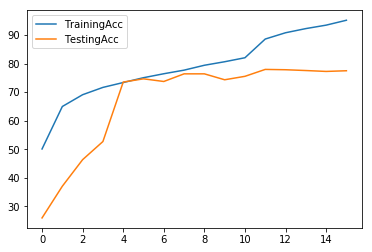

In [44]:
import matplotlib.pyplot as plt
plt.figure()
accuracy3.plot()


In [37]:
scheduler = MultiStepLR(optimizer, milestones=[10,15,20,25], gamma=0.1)

In [38]:
for i in range(15):
    scheduler.step()

In [33]:
epochs = 15
for epoch in range(12, epochs):
    start = time.clock()
    scheduler.step()
    acc_train,loss_train=train( c3d, device, train_loader, optimizer,epoch)
    acc_test,loss_test=test( c3d, device, test_loader)
    end = time.clock()
    accuracy3.loc[epoch,:]=[acc_train,acc_test]
    timing.loc[epoch,:]=[start-end]
    loss3.loc[epoch,:]=[loss_train,loss_test]

Train Epoch: 12 [14985/84027 (18%)]	Loss: 0.385262 	Training Accuracy:91% 	Learning Rate:0.0001
Train Epoch: 12 [29985/84027 (36%)]	Loss: 0.301848 	Training Accuracy:91% 	Learning Rate:0.0001
Train Epoch: 12 [44985/84027 (54%)]	Loss: 0.292516 	Training Accuracy:91% 	Learning Rate:0.0001
Train Epoch: 12 [59985/84027 (71%)]	Loss: 0.195622 	Training Accuracy:91% 	Learning Rate:0.0001
Train Epoch: 12 [74985/84027 (89%)]	Loss: 0.057323 	Training Accuracy:91% 	Learning Rate:0.0001
Train Epoch: 12 [(100%)]	Loss: 0.120172 	Training Accuracy:91% 	Learning Rate:0.0001

Test set:  Accuracy: 16311/20956 (78%),Recall: 0.7783

Train Epoch: 13 [14985/84027 (18%)]	Loss: 0.101033 	Training Accuracy:92% 	Learning Rate:0.0001
Train Epoch: 13 [29985/84027 (36%)]	Loss: 0.158604 	Training Accuracy:92% 	Learning Rate:0.0001
Train Epoch: 13 [44985/84027 (54%)]	Loss: 0.244513 	Training Accuracy:92% 	Learning Rate:0.0001
Train Epoch: 13 [59985/84027 (71%)]	Loss: 0.213521 	Training Accuracy:92% 	Learning Rate:0.

In [41]:
scheduler.get_lr()

[1.0000000000000003e-05]

In [36]:
torch.save({
  'state_dict': c3d.state_dict()
}, '../models/PlanctonTara_c156_lr10_15.pt')

In [42]:
epochs = 16
for epoch in range(15, epochs):
    start = time.clock()
    scheduler.step()
    acc_train,loss_train=train( c3d, device, train_loader, optimizer,epoch)
    acc_test,loss_test,recall_macro=test( c3d, device, test_loader)
    end = time.clock()
    accuracy3.loc[epoch,:]=[acc_train,acc_test]
    timing.loc[epoch,:]=[start-end]
    loss3.loc[epoch,:]=[loss_train,loss_test]

Train Epoch: 15 [14985/84027 (18%)]	Loss: 0.012203 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05
Train Epoch: 15 [29985/84027 (36%)]	Loss: 0.353945 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05
Train Epoch: 15 [44985/84027 (54%)]	Loss: 0.328001 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05
Train Epoch: 15 [59985/84027 (71%)]	Loss: 0.198083 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05
Train Epoch: 15 [74985/84027 (89%)]	Loss: 0.467076 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05
Train Epoch: 15 [(100%)]	Loss: 0.029734 	Training Accuracy:95% 	Learning Rate:1.0000000000000003e-05

Test set:  Accuracy: 16237/20956 (77%),Recall: 0.7748



In [58]:
acc_test,loss_test,recall_group=test( c3d, device, test_loader)


Test set:  Accuracy: 16237/20956 (77%), Recall: 0.7748, Precison: 0.7748138957816377, F1 Score: 0.7748138957816377 



/home/bgueni/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [53]:
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
recall_group=recall_score(y_true, y_pred,average=None) 

In [75]:
out156=list(zip(hierclasses3,recall_group))
out156df=pd.DataFrame(out156)
out156df.to_excel("out-156.xls")

In [76]:
torch.save({
  'state_dict': c3d.state_dict()
}, '../models/PlanctonTara_c156_lr_16.pt')

## Living or Not Living ##

In [188]:
use_cuda =  torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 10, 'pin_memory': True} if use_cuda else {}
total=84027
BS = 15
outputsize=len(hierclasses1)

In [189]:
train_loader = data.DataLoader(plancton3DDataset(gifList=trainlist,
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=3,filters=[2,3,4],
                                          keys=hierclasses1,classes_transf=classes_transf,transfpos=0,
                                          colmean=[253.63723244,252.92530955,157.54144258],
                                          colstddev=[255,255,255]), 
                               batch_size=BS, shuffle=True, collate_fn=ucf_collate, **kwargs)

In [190]:
test_loader = data.DataLoader(plancton3DDataset(gifList=testlist,
                                          rootDir="../taraImages/",
                                          channels=1,timeDepth=16,xSize=112,ySize=112,
                                          startFrame=0,endFrame=15,numFilters=3,filters=[2,3,4],
                                          keys=hierclasses1,classes_transf=classes_transf,transfpos=0,
                                          colmean=[254.52891592, 253.83549938, 157.98975485],
                                          colstddev=[255,255,255]), 
                              batch_size=1, shuffle=True, collate_fn=ucf_collate, **kwargs)

In [191]:
accuracy3 = pd.DataFrame( columns=['TrainingAcc','TestingAcc'])
loss3 = pd.DataFrame( columns=['TrainingLoss','TestingLoss'])
recall3= pd.DataFrame( columns=['TestingRecall'])
timing = pd.DataFrame( columns=['Time'])

In [192]:
from torch.optim import lr_scheduler
from torchvision.models  import *
from torch.optim.lr_scheduler import MultiStepLR
#model_alex = vgg11(num_classes=10).to(device)
import torch.backends.cudnn as cudnn

if use_cuda:
    c3d.cuda()
    c3d = torch.nn.DataParallel(c3d, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
 

optimizer = torch.optim.SGD(c3d.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, milestones=[10,15,20,28], gamma=0.1)

In [207]:
epochs = 10
for epoch in range(5, epochs):
    start = time.clock()
    scheduler.step()
    acc_train,loss_train=train( c3d, device, train_loader, optimizer,epoch)
    acc_test,loss_test,recall_group=test( c3d, device, test_loader)
    end = time.clock()
    accuracy3.loc[epoch,:]=[acc_train,acc_test]
    timing.loc[epoch,:]=[end-start]
    loss3.loc[epoch,:]=[loss_train,loss_test]

Train Epoch: 5 [14985/84027 (18%)]	Loss: 0.475663 	Training Accuracy:87% 	Learning Rate:0.001
Train Epoch: 5 [29985/84027 (36%)]	Loss: 0.295491 	Training Accuracy:87% 	Learning Rate:0.001
Train Epoch: 5 [44985/84027 (54%)]	Loss: 0.160385 	Training Accuracy:87% 	Learning Rate:0.001
Train Epoch: 5 [59985/84027 (71%)]	Loss: 0.095688 	Training Accuracy:87% 	Learning Rate:0.001
Train Epoch: 5 [74985/84027 (89%)]	Loss: 0.231538 	Training Accuracy:87% 	Learning Rate:0.001
Train Epoch: 5 [(100%)]	Loss: 0.468735 	Training Accuracy:87% 	Learning Rate:0.001

Test set:  Accuracy: 18297/20956 (87%), Recall: 0.8731, Precison: 0.8731150983012025, F1 Score: 0.8731150983012025 

Train Epoch: 6 [14985/84027 (18%)]	Loss: 0.215710 	Training Accuracy:88% 	Learning Rate:0.001
Train Epoch: 6 [29985/84027 (36%)]	Loss: 0.294006 	Training Accuracy:88% 	Learning Rate:0.001
Train Epoch: 6 [44985/84027 (54%)]	Loss: 0.239123 	Training Accuracy:88% 	Learning Rate:0.001
Train Epoch: 6 [59985/84027 (71%)]	Loss: 0.1446

In [208]:
torch.save({
  'state_dict': c3d.state_dict()
}, '../models/PlanctonTara_c2_ep10.pt')

<Figure size 432x288 with 0 Axes>

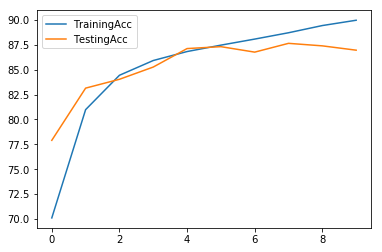

In [209]:
#Plotting Accuracy
plt.figure()
accuracy3.plot()

<Figure size 432x288 with 0 Axes>

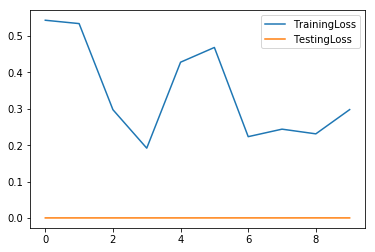

In [211]:
#Plotting Loss
plt.figure()
loss3.plot()

In [210]:
i=0
for losstest in loss3.TestingLoss:
    loss3.iloc[i,1]=losstest.item()
    i+=1

In [196]:
loss3

,TrainingLoss,TestingLoss
0,0.543588,"tensor(1.00000e-06 *\n 6.4184, device='c..."


In [198]:
weights2=torch.load('../models/PlanctonTara_c2_ep1.pt')


In [199]:
c3d2 = C3D()
if use_cuda:
    c3d2.cuda()
    c3d2 = torch.nn.DataParallel(c3d2, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True


In [179]:
weights3=weights2.copy()
f=list(weights2['state_dict'].keys())
for i in f:
    out=i.replace('module.','',1)
    weights3['state_dict'][out] = weights3['state_dict'].pop(i)

In [200]:
c3d2.load_state_dict(weights2['state_dict'])